### Load libraries

In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, recall_score, f1_score, cohen_kappa_score
from itertools import combinations
from scipy.stats import spearmanr

### Read data

In [2]:
cost = pd.read_csv('../data/processed/cost_observed.csv')
low = gpd.read_file('../data/processed/jkt_prov.shp')
high = gpd.read_file('../data/processed/jkt_dist.shp')
rf_preds = pd.read_csv('../data/processed/rf_preds.csv')

DataSourceError: ../data/processed/jkt_prov.shp: No such file or directory

In [2181]:
rf_preds.dropna()["Predicted_Cases"].nunique()

40

### Process data

In [2182]:
#first method of disaggregation, divide the cases evenly among all the districts
#firstly, extract the total number of cases in DKI Jakarta, so high['Cases'] when high['Province'] == 'DKI Jakarta', for every year
df_jakarta = low[low['Province'] == 'DKI Jakarta']
df_java = low[low['Province'] == 'Jawa Barat']

df_jakarta.head()

,Province,Year,Cases,Population,HDI,Area_sq_km,Pop_den,urbanicity,geometry
0,DKI Jakarta,2020,1226,804069,80.345000,664.01,1210.929052,0.918091,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."
1,DKI Jakarta,2021,1061,799633,80.633333,664.01,1204.248430,0.918091,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."
2,DKI Jakarta,2022,2123,795198,81.146667,661.23,1202.604238,0.918091,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."
3,DKI Jakarta,2023,1564,790763,81.708333,660.98,1196.349360,0.918091,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."


In [2183]:
#create a dataframe containing total number of cases in dengue in each year from dki jakarta n west java df
df_jakarta_yearly_total_cases = pd.DataFrame(df_jakarta.groupby('Year')['Cases'].sum())
df_java_yearly_total_cases = pd.DataFrame(df_java.groupby('Year')['Cases'].sum())

In [2184]:
#check head
df_jakarta_yearly_total_cases.head()

,Cases
Year,
2020,1226
2021,1061
2022,2123
2023,1564


### Disaggregation with equal proportions and NMB adjustments

In [2185]:
#from this, extract the total number of districts in DKI Jakarta from high df, so count the number of unique values of district when province column = dki jakarta
df_jakarta_districts = len(pd.DataFrame(high[high['Province'] == 'DKI Jakarta']['District'].unique()))
df_java_districts = len(pd.DataFrame(high[high['Province'] == 'Jawa Barat']['District'].unique()))

In [2186]:
print(df_jakarta_districts)

6


In [2187]:
#list out all the district - level dengue cases estimates each year
year_2020_jkt = int(df_jakarta_yearly_total_cases.loc[2020] / df_jakarta_districts)
year_2021_jkt = int(df_jakarta_yearly_total_cases.loc[2021] / df_jakarta_districts)
year_2022_jkt = int(df_jakarta_yearly_total_cases.loc[2022] / df_jakarta_districts)
year_2023_jkt = int(df_jakarta_yearly_total_cases.loc[2023] / df_jakarta_districts)

year_2020_java = int(df_java_yearly_total_cases.loc[2020] / df_java_districts)
year_2021_java = int(df_java_yearly_total_cases.loc[2021] / df_java_districts)
year_2022_java = int(df_java_yearly_total_cases.loc[2022] / df_java_districts)
year_2023_java = int(df_java_yearly_total_cases.loc[2023] / df_java_districts)

C:\Users\jessi\AppData\Local\Temp\ipykernel_55408\516498921.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2020_jkt = int(df_jakarta_yearly_total_cases.loc[2020] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_55408\516498921.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2021_jkt = int(df_jakarta_yearly_total_cases.loc[2021] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_55408\516498921.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2022_jkt = int(df_jakarta_yearly_total_cases.loc[2022] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_55408\516498921.py:5: FutureWarning: Calling int on a single element Series is depr

In [2188]:
#append the disaggregated counts to the high_res file ina  new column called cases_bm_equal, only if the Province column is dki jakarta
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2020), 'cases_bm_equal'] = year_2020_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2021), 'cases_bm_equal'] = year_2021_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2022), 'cases_bm_equal'] = year_2022_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2023), 'cases_bm_equal'] = year_2023_jkt

high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2020), 'cases_bm_equal'] = year_2020_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2021), 'cases_bm_equal'] = year_2021_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2022), 'cases_bm_equal'] = year_2022_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2023), 'cases_bm_equal'] = year_2023_java

In [2189]:
high.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,geometry,cases_bm_equal
0,BANDUNG,2020,1767.96,72.39,Jawa Barat,2295,3623790,2049.701351,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",837.0
1,BANDUNG,2021,1767.96,72.73,Jawa Barat,2002,3665655,2073.381185,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",886.0
2,BANDUNG,2022,1767.96,73.16,Jawa Barat,4191,3707523,2097.062716,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1346.0
3,BANDUNG,2023,1767.96,73.74,Jawa Barat,1005,3749391,2120.744248,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",715.0
4,BANDUNG BARAT,2020,1305.77,68.08,Jawa Barat,966,1788336,1369.564318,0.079001,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",837.0


In [2190]:
#append the cases_bm_equal column to NBM table
nbm = nbm.merge(high[["Province", "District", "Year", "cases_bm_equal"]], on = ["Province", "District", "Year"], how = "left")

In [2191]:
len(nbm.dropna())

132

In [2192]:
#calculate NMB for disaggregation with equal proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
nbm['cost_factor'] = nbm['cases_bm_equal'] / (nbm['burden_non_vaccine'] + nbm['burden_vaccine'])

nbm['qaly_lost_scaled_vaccine'] = nbm['qaly_le_scaled_vaccine'] * nbm['cost_factor']
nbm['qaly_lost_scaled_nonvaccine'] = nbm['qaly_le_scaled_nonvaccine'] * nbm['cost_factor']


In [2193]:
# Scale costs
nbm['healthcare_cost_vaccine_scaled'] = nbm['healthcare_cost_vaccine'] * nbm['cost_factor']
nbm['healthcare_cost_nonvaccine_scaled'] = nbm['healthcare_cost_non_vaccine'] * nbm['cost_factor']
nbm['payer_cost_vaccine_scaled'] = nbm['payer_cost_vaccine'] * nbm['cost_factor']
nbm['payer_cost_nonvaccine_scaled'] = nbm['payer_cost_non_vaccine'] * nbm['cost_factor']

In [2194]:
#compute nbm
nbm['nmb_healthcare_equal_bm'] = 3 * 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['healthcare_cost_vaccine_scaled'] - nbm['healthcare_cost_nonvaccine_scaled'])
nbm['nmb_payer_equal_bm']= 3 * 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['payer_cost_vaccine_scaled'] - nbm['payer_cost_nonvaccine_scaled'])

In [2195]:
nbm.head()

,Unnamed: 0,District,Province,Cases,Population,Year,nmb_healthcare_observed,nmb_payer_observed,burden_non_vaccine,burden_vaccine,...,cases_bm_equal,cost_factor,qaly_lost_scaled_vaccine,qaly_lost_scaled_nonvaccine,healthcare_cost_vaccine_scaled,healthcare_cost_nonvaccine_scaled,payer_cost_vaccine_scaled,payer_cost_nonvaccine_scaled,nmb_healthcare_equal_bm,nmb_payer_equal_bm
0,0,BANDUNG,Jawa Barat,2295,3623790,2020,-4.492428,-4.491871,382416,264217,...,837.0,0.001294,0.000661,0.000661,1.728506,0.090099,1.692588,0.054383,-1.638400,-1.638197
1,1,BANDUNG,Jawa Barat,2002,3665655,2021,-3.918885,-3.918399,382416,264217,...,886.0,0.001370,0.000700,0.000700,1.829697,0.095374,1.791676,0.057567,-1.734316,-1.734101
2,2,BANDUNG,Jawa Barat,4191,3707523,2022,-8.203819,-8.202802,382416,264217,...,1346.0,0.002082,0.001063,0.001063,2.779653,0.144890,2.721891,0.087455,-2.634751,-2.634424
3,3,BANDUNG,Jawa Barat,1005,3749391,2023,-1.967272,-1.967028,382416,264217,...,715.0,0.001106,0.000565,0.000565,1.476562,0.076966,1.445878,0.046456,-1.399589,-1.399416
4,4,BANDUNG BARAT,Jawa Barat,966,1788336,2020,-1.890930,-1.890696,382416,264217,...,837.0,0.001294,0.000650,0.000650,1.728506,0.090099,1.692588,0.054383,-1.638400,-1.638197


### Population-proportion disaggregation and NMB calculations

In [2196]:
#get df containing yearly total populations
df_jakarta_yearly_total_pop = pd.DataFrame(df_jakarta.groupby('Year')['Population'].sum())
df_java_yearly_total_pop = pd.DataFrame(df_java.groupby('Year')['Population'].sum())

df_jakarta_yearly_total_pop.head()

,Population
Year,
2020,804069
2021,799633
2022,795198
2023,790763


In [2197]:
#merge the two dfs by Year
df_jakarta_final = df_jakarta_yearly_total_cases.merge(df_jakarta_yearly_total_pop, on='Year')
df_java_final = df_java_yearly_total_cases.merge(df_java_yearly_total_pop, on='Year')

#get another column called df_jakarta_final and df_java_final called Province, for merging
df_jakarta_final['Province'] = 'DKI Jakarta'
df_java_final['Province'] = 'Jawa Barat'

#append the suffix _Prov to both "Cases" and "Population" c0olumns in df_jakarta_final and df_java_final:
df_jakarta_final.columns = [col + '_Prov' if col in ['Cases', 'Population'] else col for col in df_jakarta_final.columns]
df_java_final.columns = [col + '_Prov' if col in ['Cases', 'Population'] else col for col in df_java_final.columns]

In [2198]:
# Reset index of df_jakarta_final and df_java_final to make 'Year' a regular column
df_jakarta_final = df_jakarta_final.reset_index()
df_java_final = df_java_final.reset_index()
#check
df_jakarta_final.head()

,Year,Cases_Prov,Population_Prov,Province
0,2020,1226,804069,DKI Jakarta
1,2021,1061,799633,DKI Jakarta
2,2022,2123,795198,DKI Jakarta
3,2023,1564,790763,DKI Jakarta


In [2199]:
#merge df_jakarta_final and df_java_final tgt by row
df_final = pd.concat([df_jakarta_final, df_java_final], axis=0)

In [2200]:
#now append this to the high-res dataset: so it means that if the year is 2020 cases_prop_bm = high_res["Population"]/df_jakarta_final["Population"] * df_jakarta_final["Cases"]

#merge to the high_res df by Year and Province
high = pd.merge(high, df_final[['Year', 'Province', 'Population_Prov', 'Cases_Prov']], on=['Year', 'Province'], how='left')


In [2201]:
high.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,geometry,cases_bm_equal,Population_Prov,Cases_Prov
0,BANDUNG,2020,1767.96,72.39,Jawa Barat,2295,3623790,2049.701351,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",837.0,48274162,22613
1,BANDUNG,2021,1767.96,72.73,Jawa Barat,2002,3665655,2073.381185,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",886.0,48778844,23948
2,BANDUNG,2022,1767.96,73.16,Jawa Barat,4191,3707523,2097.062716,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1346.0,49283556,36365
3,BANDUNG,2023,1767.96,73.74,Jawa Barat,1005,3749391,2120.744248,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",715.0,49788238,19328
4,BANDUNG BARAT,2020,1305.77,68.08,Jawa Barat,966,1788336,1369.564318,0.079001,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",837.0,48274162,22613


In [2202]:
#calculate the disaggregation by multiplying the total num of cases per province with the pop in the district / pop in the province
high['cases_prop_bm'] = (high['Population'] / high['Population_Prov']) * high['Cases_Prov']

In [2203]:
#nbm calculations
#merge this with nbm df
nbm = pd.merge(nbm, high[['Province', 'District', 'Year', 'cases_prop_bm']], on=['Province', 'District', 'Year'], how='left')

In [2204]:
len(nbm.dropna())

132

In [2205]:
#calculate nbm for disaggregation with population-based proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
nbm['cost_factor'] = nbm['cases_prop_bm'] / (nbm['burden_non_vaccine'] + nbm['burden_vaccine'])

nbm['qaly_lost_scaled_vaccine'] = nbm['qaly_le_scaled_vaccine'] * nbm['cost_factor']
nbm['qaly_lost_scaled_nonvaccine'] = nbm['qaly_le_scaled_nonvaccine'] * nbm['cost_factor']


In [2206]:
# Scale costs
nbm['healthcare_cost_vaccine_scaled'] = nbm['healthcare_cost_vaccine'] * nbm['cost_factor']
nbm['healthcare_cost_nonvaccine_scaled'] = nbm['healthcare_cost_non_vaccine'] * nbm['cost_factor']
nbm['payer_cost_vaccine_scaled'] = nbm['payer_cost_vaccine'] * nbm['cost_factor']
nbm['payer_cost_nonvaccine_scaled'] = nbm['payer_cost_non_vaccine'] * nbm['cost_factor']

In [2207]:
#compute nbm
nbm['nmb_healthcare_equal_bm'] = 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['healthcare_cost_vaccine_scaled'] - nbm['healthcare_cost_nonvaccine_scaled'])
nbm['nmb_payer_equal_bm']= 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['payer_cost_vaccine_scaled'] - nbm['payer_cost_nonvaccine_scaled'])

In [2208]:
#compute nbm
nbm['nmb_healthcare_prop_bm'] = 3 * 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['healthcare_cost_vaccine_scaled'] - nbm['healthcare_cost_nonvaccine_scaled'])
nbm['nmb_payer_prop_bm']= 3 * 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['payer_cost_vaccine_scaled'] - nbm['payer_cost_nonvaccine_scaled'])

In [2209]:
nbm.head()

,Unnamed: 0,District,Province,Cases,Population,Year,nmb_healthcare_observed,nmb_payer_observed,burden_non_vaccine,burden_vaccine,...,qaly_lost_scaled_nonvaccine,healthcare_cost_vaccine_scaled,healthcare_cost_nonvaccine_scaled,payer_cost_vaccine_scaled,payer_cost_nonvaccine_scaled,nmb_healthcare_equal_bm,nmb_payer_equal_bm,cases_prop_bm,nmb_healthcare_prop_bm,nmb_payer_prop_bm
0,0,BANDUNG,Jawa Barat,2295,3623790,2020,-4.492428,-4.491871,382416,264217,...,0.001340,3.505517,0.182726,3.432671,0.110293,-3.322785,-3.322373,1697.487017,-3.322775,-3.322363
1,1,BANDUNG,Jawa Barat,2002,3665655,2021,-3.918885,-3.918399,382416,264217,...,0.001422,3.716506,0.193724,3.639276,0.116931,-3.522777,-3.522340,1799.655317,-3.522766,-3.522330
2,2,BANDUNG,Jawa Barat,4191,3707523,2022,-8.203819,-8.202802,382416,264217,...,0.002161,5.649512,0.294483,5.532114,0.177748,-5.355021,-5.354357,2735.680719,-5.355005,-5.354341
3,3,BANDUNG,Jawa Barat,1005,3749391,2023,-1.967272,-1.967028,382416,264217,...,0.001149,3.005844,0.156681,2.943382,0.094572,-2.849159,-2.848806,1455.529100,-2.849150,-2.848797
4,4,BANDUNG BARAT,Jawa Barat,966,1788336,2020,-1.890930,-1.890696,382416,264217,...,0.000650,1.729968,0.090175,1.694019,0.054429,-1.639791,-1.639587,837.707798,-1.639786,-1.639582


### Random-forest-based (hdi and pop den) aggregation and icer calculations

In [2210]:
#merge the rf_preds cases to the high and nbm dfs:
#rename Predicted_Cases to rf_preds
rf_preds = rf_preds.rename(columns={'Predicted_Cases': 'rf_preds'})
high = pd.merge(high, rf_preds[["HDI","urbanicity", "rf_preds"]], on = ["HDI","urbanicity"], how='left')

In [2211]:
len(rf_preds['rf_preds'].unique())

40

In [2212]:
#check the columns for high
high.dropna(subset=['rf_preds'])["rf_preds"].shape[0]

40

In [2213]:
high.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,geometry,cases_bm_equal,Population_Prov,Cases_Prov,cases_prop_bm,rf_preds
0,BANDUNG,2020,1767.96,72.39,Jawa Barat,2295,3623790,2049.701351,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",837.0,48274162,22613,1697.487017,NaN
1,BANDUNG,2021,1767.96,72.73,Jawa Barat,2002,3665655,2073.381185,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",886.0,48778844,23948,1799.655317,NaN
2,BANDUNG,2022,1767.96,73.16,Jawa Barat,4191,3707523,2097.062716,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1346.0,49283556,36365,2735.680719,NaN
3,BANDUNG,2023,1767.96,73.74,Jawa Barat,1005,3749391,2120.744248,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",715.0,49788238,19328,1455.529100,1696.349339
4,BANDUNG BARAT,2020,1305.77,68.08,Jawa Barat,966,1788336,1369.564318,0.079001,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",837.0,48274162,22613,837.707798,517.197756


In [2214]:
nbm = nbm.merge(high[["Year", "District", "rf_preds"]], on = ["Year", "District"], how = "left")

In [2215]:
nbm.isna().sum()

Unnamed: 0                            0
District                              0
Province                              0
Cases                                 0
Population                            0
Year                                  0
nmb_healthcare_observed               0
nmb_payer_observed                    0
burden_non_vaccine                    0
burden_vaccine                        0
qaly_le_scaled_vaccine                0
qaly_le_scaled_nonvaccine             0
healthcare_cost_non_vaccine           0
healthcare_cost_vaccine               0
payer_cost_non_vaccine                0
payer_cost_vaccine                    0
cases_bm_equal                        0
cost_factor                           0
qaly_lost_scaled_vaccine              0
qaly_lost_scaled_nonvaccine           0
healthcare_cost_vaccine_scaled        0
healthcare_cost_nonvaccine_scaled     0
payer_cost_vaccine_scaled             0
payer_cost_nonvaccine_scaled          0
nmb_healthcare_equal_bm               0


In [2216]:
# calculate nbm for rf
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
nbm['cost_factor'] = nbm['rf_preds'] / (nbm['burden_non_vaccine'] + nbm['burden_vaccine'])

nbm['qaly_lost_scaled_vaccine'] = nbm['qaly_le_scaled_vaccine'] * nbm['cost_factor']
nbm['qaly_lost_scaled_nonvaccine'] = nbm['qaly_le_scaled_nonvaccine'] * nbm['cost_factor']

In [2217]:
# Scale costs
nbm['healthcare_cost_vaccine_scaled'] = nbm['healthcare_cost_vaccine'] * nbm['cost_factor']
nbm['healthcare_cost_nonvaccine_scaled'] = nbm['healthcare_cost_non_vaccine'] * nbm['cost_factor']
nbm['payer_cost_vaccine_scaled'] = nbm['payer_cost_vaccine'] * nbm['cost_factor']
nbm['payer_cost_nonvaccine_scaled'] = nbm['payer_cost_non_vaccine'] * nbm['cost_factor']

In [2218]:
#compute nbm
nbm['nmb_healthcare_rf'] = 3 * 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['healthcare_cost_vaccine_scaled'] - nbm['healthcare_cost_nonvaccine_scaled'])
nbm['nmb_payer_rf']= 3 * 3859 * abs(nbm['qaly_lost_scaled_vaccine'] - nbm['qaly_lost_scaled_nonvaccine']) - abs(nbm['payer_cost_vaccine_scaled'] - nbm['payer_cost_nonvaccine_scaled'])

In [2219]:
print(nbm.shape[0])


132


# Evaluate the Predicted Cases produced by different methods

### Evaluate the ICER calculations produced by different models and which one is closest to the observed ones

In [2220]:
nbm = nbm.dropna(subset = ["rf_preds"])

In [2221]:
nbm.head()

,Unnamed: 0,District,Province,Cases,Population,Year,nmb_healthcare_observed,nmb_payer_observed,burden_non_vaccine,burden_vaccine,...,payer_cost_vaccine_scaled,payer_cost_nonvaccine_scaled,nmb_healthcare_equal_bm,nmb_payer_equal_bm,cases_prop_bm,nmb_healthcare_prop_bm,nmb_payer_prop_bm,rf_preds,nmb_healthcare_rf,nmb_payer_rf
3,3,BANDUNG,Jawa Barat,1005,3749391,2023,-1.967272,-1.967028,382416,264217,...,3.430370,0.110219,-2.849159,-2.848806,1455.529100,-2.849150,-2.848797,1696.349339,-3.320548,-3.320137
4,4,BANDUNG BARAT,Jawa Barat,966,1788336,2020,-1.890930,-1.890696,382416,264217,...,1.045881,0.033604,-1.639791,-1.639587,837.707798,-1.639786,-1.639582,517.197756,-1.012398,-1.012272
7,7,BANDUNG BARAT,Jawa Barat,1322,1868213,2023,-2.587795,-2.587474,382416,264217,...,1.701978,0.054685,-1.419654,-1.419478,725.248017,-1.419649,-1.419473,841.643388,-1.647489,-1.647285
10,10,BEKASI,Jawa Barat,1003,3204245,2022,-1.963357,-1.963114,382416,264217,...,1.409604,0.045291,-4.628104,-4.627530,2364.325525,-4.628090,-4.627516,697.062076,-1.364476,-1.364307
12,12,BOGOR,Jawa Barat,1256,5427068,2020,-2.458601,-2.458296,382416,264217,...,4.123395,0.132486,-4.976277,-4.975660,2542.194076,-4.976262,-4.975645,2039.056561,-3.991387,-3.990892



 Dengue Case Prediction Evaluation
----------------------------------------
Random Forest
   MAE  : 408.20 cases
   RMSE : 545.65 cases
   Avg MAE as % of avg observed cases (by district): 98.08%
   Spearman ρ : 0.71

Prop-Based Split
   MAE  : 455.28 cases
   RMSE : 675.19 cases
   Avg MAE as % of avg observed cases (by district): 60.08%
   Spearman ρ : 0.64

Equal-Based Split
   MAE  : 413.38 cases
   RMSE : 582.29 cases
   Avg MAE as % of avg observed cases (by district): 171.53%
   Spearman ρ : 0.45



C:\Users\jessi\AppData\Local\Temp\ipykernel_55408\4219996329.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g['Cases'], g[pred_col]) / g['Cases'].mean() * 100)
C:\Users\jessi\AppData\Local\Temp\ipykernel_55408\4219996329.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g['Cases'], g[pred_col]) / g['Cases'].mean() * 100)
C:\U

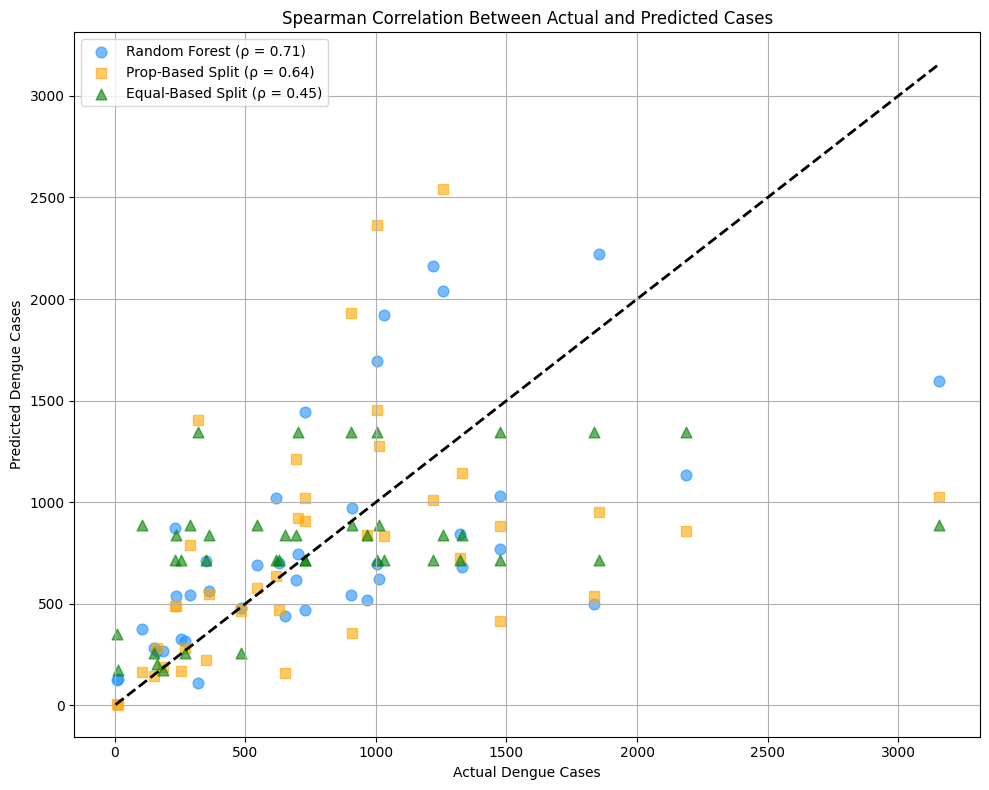

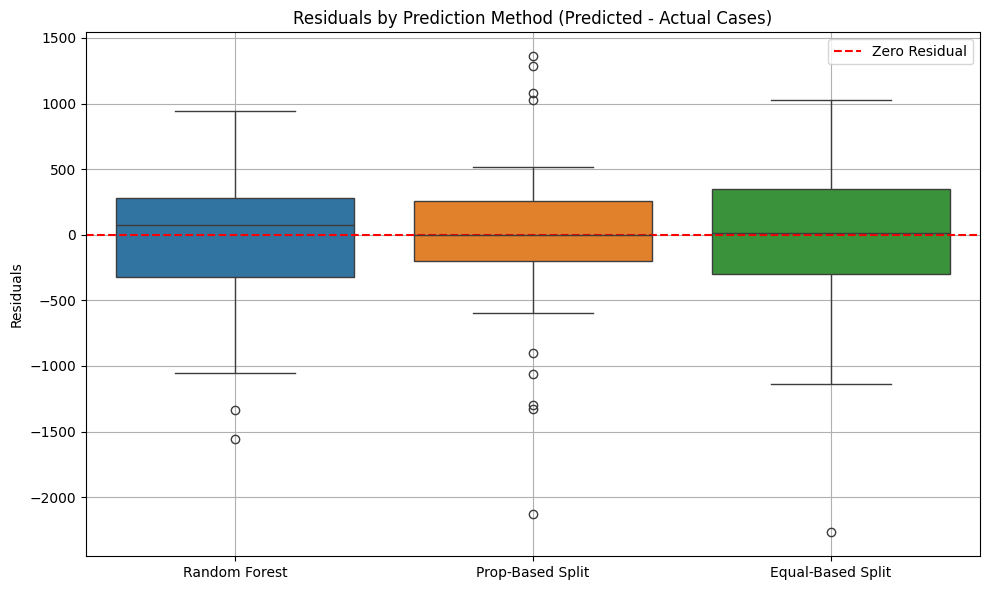

In [2224]:
# --- Define methods ---
methods = {
    'Random Forest': 'rf_preds',
    'Prop-Based Split': 'cases_prop_bm',
    'Equal-Based Split': 'cases_bm_equal'
}

residuals_dict = {}
preds_dict = {}

print("\n Dengue Case Prediction Evaluation\n" + "-" * 40)

for name, pred_col in methods.items():
    y_true = nbm['Cases'].values
    y_pred = nbm[pred_col].values
    residuals = y_pred - y_true  # You had abs before, but for residuals boxplot, we often use signed error

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # District-level MAE as percentage of average true cases
    district_mae_pct = (
        nbm.groupby('District')
        .apply(lambda g: mean_absolute_error(g['Cases'], g[pred_col]) / g['Cases'].mean() * 100)
    )
    avg_mae_pct = district_mae_pct.mean()

    # Spearman correlation
    rho, _ = spearmanr(y_true, y_pred)
    
    # Store residuals and prediction info for later use
    residuals_dict[name] = residuals
    preds_dict[name] = {'true': y_true, 'pred': y_pred, 'rho': rho}

    # Print metrics
    print(f"{name}")
    print(f"   MAE  : {mae:.2f} cases")
    print(f"   RMSE : {rmse:.2f} cases")
    print(f"   Avg MAE as % of avg observed cases (by district): {avg_mae_pct:.2f}%")
    print(f"   Spearman ρ : {rho:.2f}\n")

# --- Spearman Correlation Plot ---
plt.figure(figsize=(10, 8))
markers = ['o', 's', '^']
colors = ['dodgerblue', 'orange', 'green']

for i, (name, values) in enumerate(preds_dict.items()):
    plt.scatter(values['true'], values['pred'],
                label=f"{name} (ρ = {values['rho']:.2f})",
                alpha=0.6, marker=markers[i], s=60, color=colors[i])

min_val = min(nbm['Cases'].min(), *[nbm[col].min() for col in methods.values()])
max_val = max(nbm['Cases'].max(), *[nbm[col].max() for col in methods.values()])
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel("Actual Dengue Cases")
plt.ylabel("Predicted Dengue Cases")
plt.title("Spearman Correlation Between Actual and Predicted Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Residual Boxplot ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(residuals_dict))
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title("Residuals by Prediction Method (Predicted - Actual Cases)")
plt.ylabel("Residuals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



 NMB Evaluation from Healthcare Provider's Perspective
--------------------------------------------------
RF - Spearman ρ: 0.72
Equal Split - Spearman ρ: 0.64
Pop-Based Split - Spearman ρ: 0.64


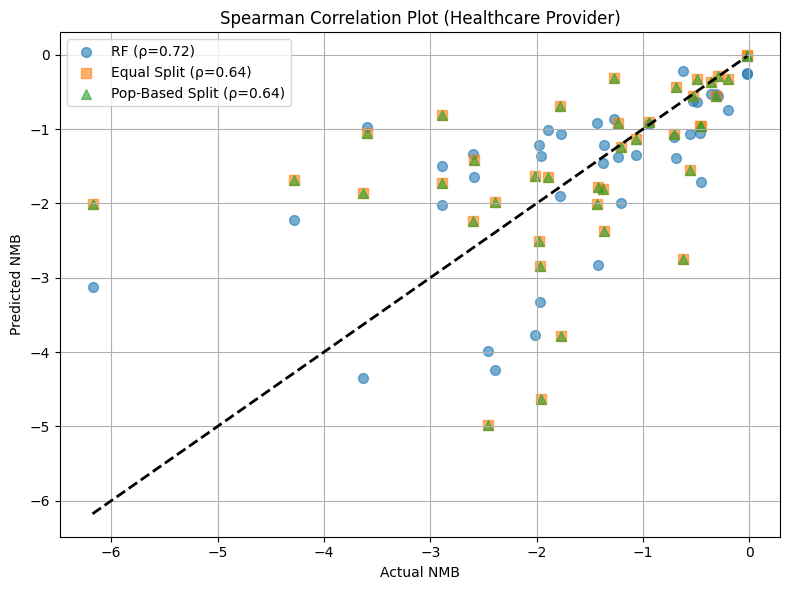

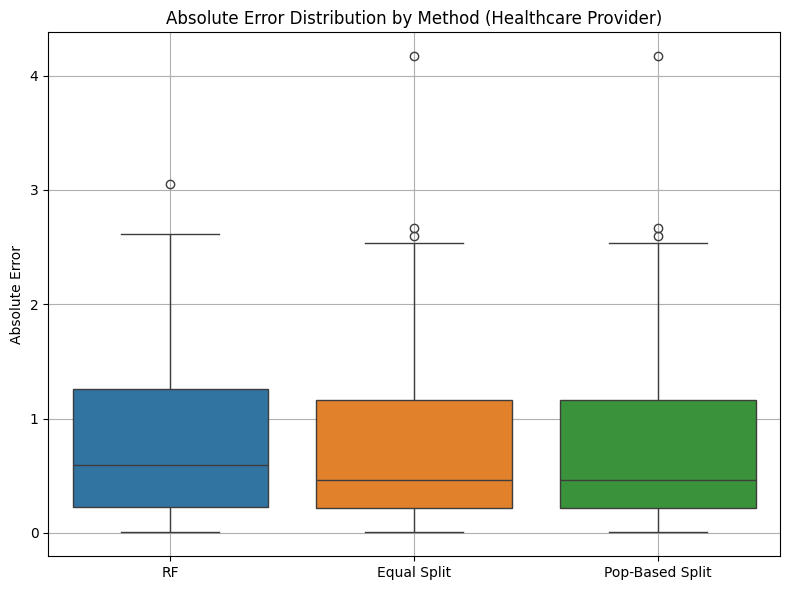

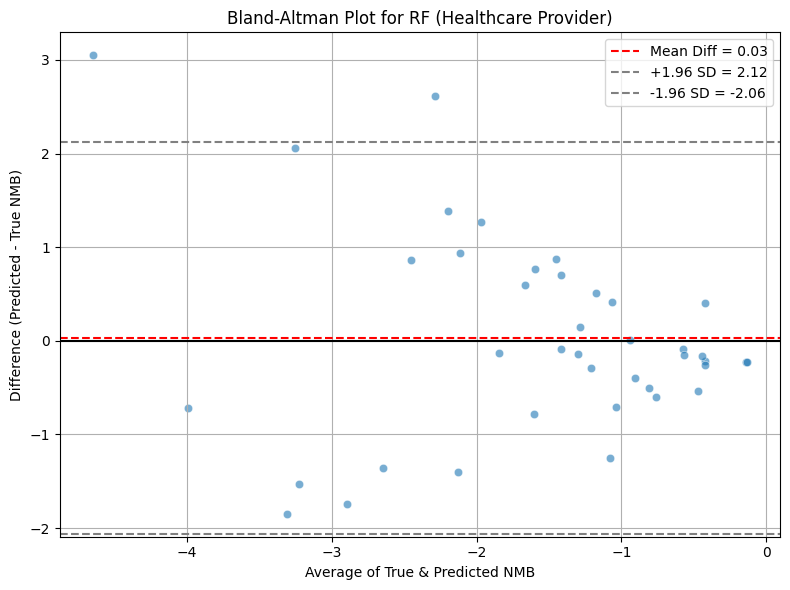

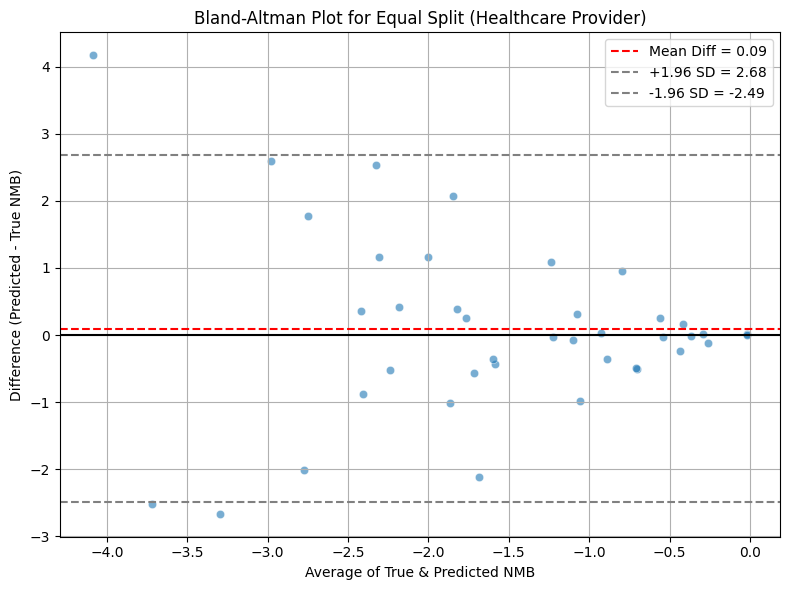

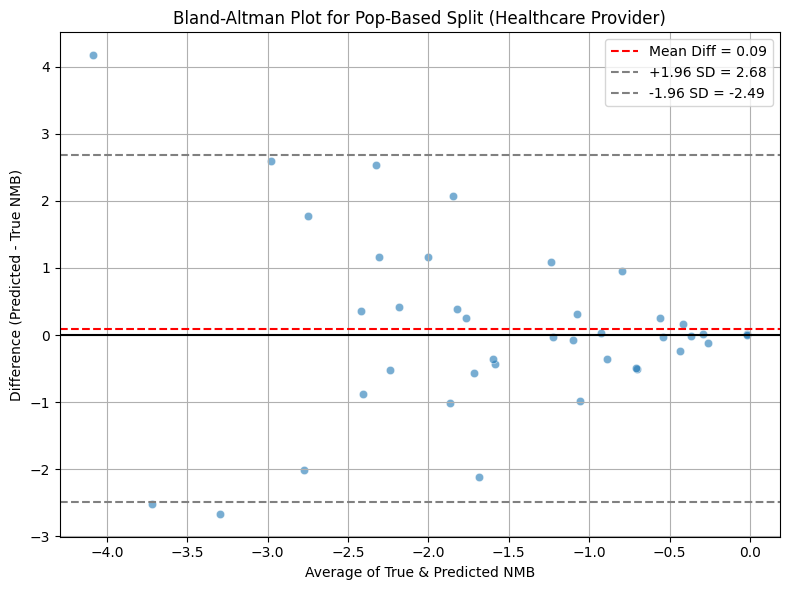



 NMB Evaluation from Payer's Perspective
--------------------------------------------------
RF - Spearman ρ: 0.72
Equal Split - Spearman ρ: 0.64
Pop-Based Split - Spearman ρ: 0.64


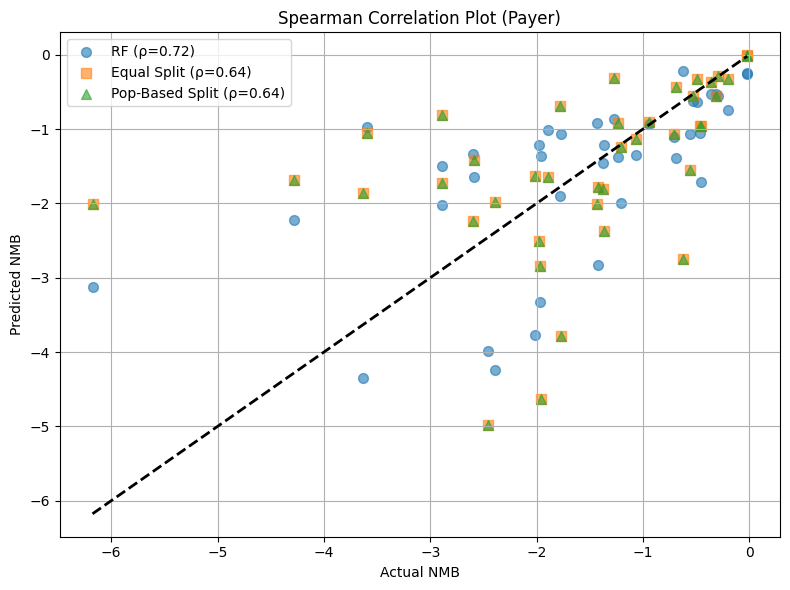

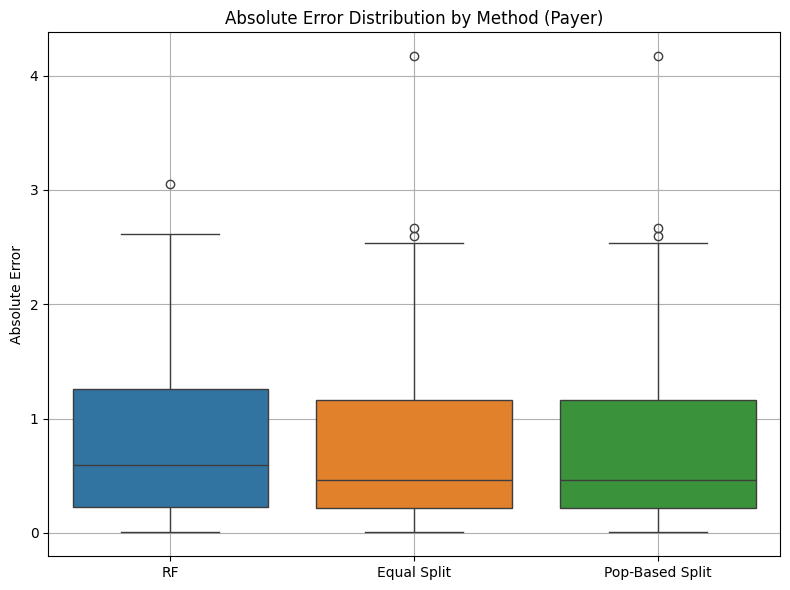

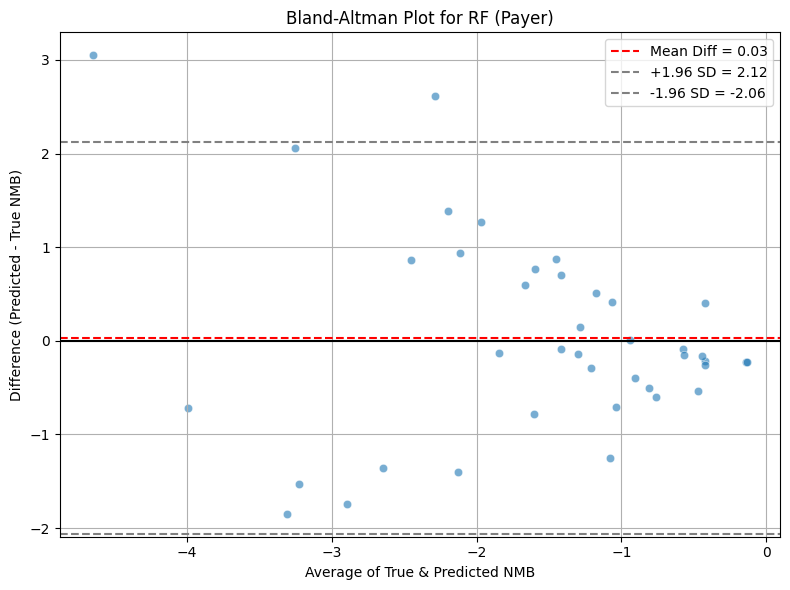

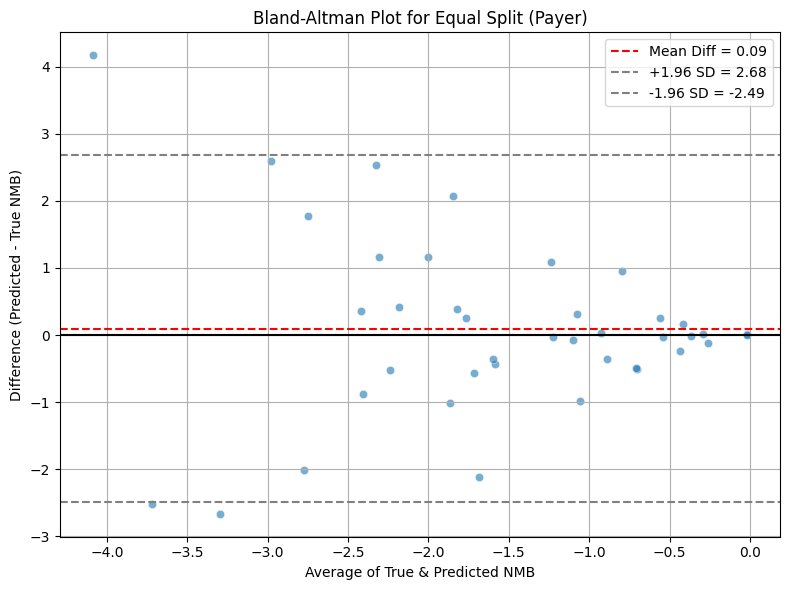

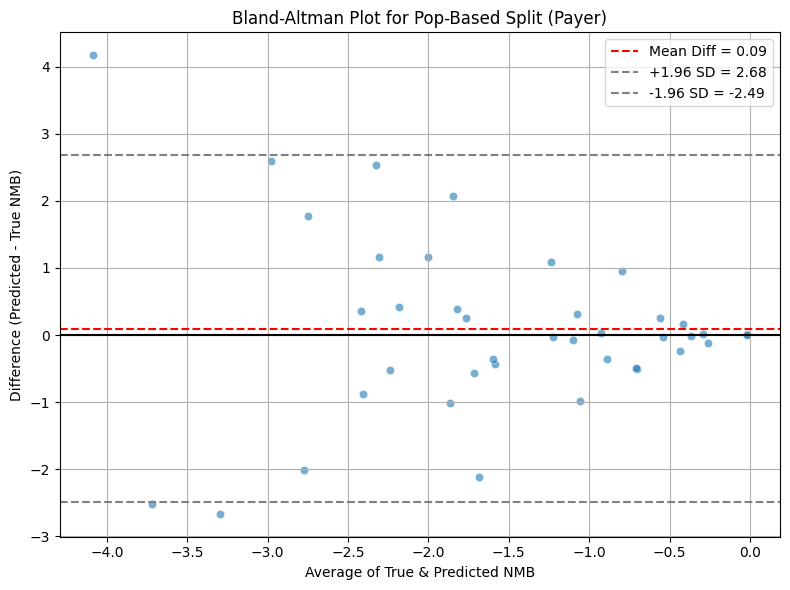

In [2223]:
# Define NMB method columns per perspective
perspectives = {
    'Healthcare Provider': {
        'true': 'nmb_healthcare_observed',
        'methods': {
            'RF': 'nmb_healthcare_rf',
            'Equal Split': 'nmb_healthcare_equal_bm',
            'Pop-Based Split': 'nmb_healthcare_prop_bm'
        }
    },
    'Payer': {
        'true': 'nmb_payer_observed',
        'methods': {
            'RF': 'nmb_payer_rf',
            'Equal Split': 'nmb_payer_equal_bm',
            'Pop-Based Split': 'nmb_payer_prop_bm'
        }
    }
}

for perspective, setup in perspectives.items():
    print(f"\n\n NMB Evaluation from {perspective}'s Perspective\n{'-'*50}")
    
    true_col = setup['true']
    methods_dict = setup['methods']
    method_names = list(methods_dict.keys())

    y_true_val = nbm[true_col].values

    abs_errors = {}
    preds_dict = {}

    # --- Error and correlation ---
    for name, pred_col in methods_dict.items():
        y_pred_val = nbm[pred_col].values
        rho, _ = spearmanr(y_true_val, y_pred_val)

        print(f"{name} - Spearman ρ: {rho:.2f}")
        
        abs_errors[name] = np.abs(y_pred_val - y_true_val)
        preds_dict[name] = {'true': y_true_val, 'pred': y_pred_val}

    # --- Spearman Correlation Plot ---
    plt.figure(figsize=(8, 6))
    markers = ['o', 's', '^']
    for i, (name, values) in enumerate(preds_dict.items()):
        rho, _ = spearmanr(values['true'], values['pred'])
        plt.scatter(values['true'], values['pred'],
                    label=f"{name} (ρ={rho:.2f})",
                    alpha=0.6, marker=markers[i], s=50)

    min_val, max_val = y_true_val.min(), y_true_val.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel("Actual NMB")
    plt.ylabel("Predicted NMB")
    plt.title(f"Spearman Correlation Plot ({perspective})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Boxplot of Absolute Errors ---
    abs_errors_df = pd.DataFrame({
        name: pd.Series(abs_errors[name]).reset_index(drop=True)
        for name in abs_errors
    })
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=abs_errors_df)
    plt.title(f"Absolute Error Distribution by Method ({perspective})")
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Bland-Altman Plots ---
    for name, values in preds_dict.items():
        true_vals = values['true']
        pred_vals = values['pred']

        avg_vals = (true_vals + pred_vals) / 2
        diff_vals = pred_vals - true_vals
        mean_diff = np.mean(diff_vals)
        std_diff = np.std(diff_vals)

        loa_upper = mean_diff + 1.96 * std_diff
        loa_lower = mean_diff - 1.96 * std_diff

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=avg_vals, y=diff_vals, alpha=0.6)
        plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Diff = {mean_diff:.2f}")
        plt.axhline(loa_upper, color='gray', linestyle='--', label=f"+1.96 SD = {loa_upper:.2f}")
        plt.axhline(loa_lower, color='gray', linestyle='--', label=f"-1.96 SD = {loa_lower:.2f}")
        plt.axhline(0, color='black', linestyle='-')
        plt.title(f"Bland-Altman Plot for {name} ({perspective})")
        plt.xlabel("Average of True & Predicted NMB")
        plt.ylabel("Difference (Predicted - True NMB)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
